# 01. Clean Data and EDA
## Purpose: Stroke Prediction

According to the NIH National Heart, Lung, and Blood Institute (HHLI):

>Strokes are caused by blocked blood flow to the brain (ischemic stroke) or sudden bleeding in the brain (hemorrhagic stroke). Many things raise your risk of stroke, and many of these can be changed to help prevent a stroke or prevent another stroke.

The aim of this analysis is to compare different models' accuracy when predicting a stroke based on key health factors.

---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

## 1. Data
### 1.1. Data Description
* This is data from the CDC's 2020 BRFSS with 401,958 survey responses. Original data can be found [here](https://www.cdc.gov/brfss/annual_data/annual_2020.html)
* About the BRFSS:

  >"Behavioral Risk Factor Surveillance System (BRFSS) is the nation’s premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services."

**Read in raw data**

In [3]:
input_file = '../data/raw/2020_BRFSS.csv'
raw_df = pd.read_csv(input_file)
raw_df

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_RFPSA23,_CLNSCPY,_SGMSCPY,_SGMS10Y,_RFBLDS4,_STOLDNA,_VIRCOLN,_SBONTIM,_CRCREC1,_AIDTST4
0,1.0,1.0,1042020,1,4,2020,1100.0,2020000001,2.020000e+09,1.0,...,NaN,1.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0
1,1.0,1.0,2072020,2,7,2020,1200.0,2020000002,2.020000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
2,1.0,1.0,1232020,1,23,2020,1100.0,2020000003,2.020000e+09,1.0,...,NaN,1.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0
3,1.0,1.0,1092020,1,9,2020,1100.0,2020000004,2.020000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,1.0,1.0,1042020,1,4,2020,1100.0,2020000005,2.020000e+09,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401953,72.0,11.0,2192021,2,19,2021,1100.0,2020004940,2.020005e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
401954,72.0,11.0,2142021,2,14,2021,1100.0,2020004941,2.020005e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
401955,72.0,11.0,2142021,2,14,2021,1100.0,2020004942,2.020005e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
401956,72.0,11.0,3172021,3,17,2021,1100.0,2020004943,2.020005e+09,NaN,...,1.0,1.0,3.0,3.0,1.0,3.0,3.0,2.0,1.0,1.0


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401958 entries, 0 to 401957
Columns: 279 entries, _STATE to _AIDTST4
dtypes: float64(274), int64(5)
memory usage: 855.6 MB


### 1.2. Clean data for Analysis
Based on information from the [NHLI](https://www.nhlbi.nih.gov/health/stroke/causes), the variables included in the BRFSS survey that match stroke risk factors:

- Coronary heart disease - CVDCRHD4 
- Diabetes - DIABETE4
- Smoking - _SMOKER3 
- Arthritis - _DRDXAR2
- Age - _AGEG5YR  
- Sex - _SEX
- Race/ethnicity - _RACE
- Obesity and Overweight - _RFBMI5
- Heavy Alcohol Consumption (adult men >=14 drinks per week; adult women>=7 drinks per week) - _RFDRHV7
- Physical Inactivity - _TOTINDA
- Poor mental health - MENTHLTH

The variable indicating a stroke that will be used as the class: 
- CVDSTRK3


In [6]:
# subset data 
select_columns = ['_AGEG5YR', '_SEX', '_RACE', '_RFBMI5','CVDCRHD4', 'DIABETE4', '_SMOKER3', 
                  '_DRDXAR2', '_RFDRHV7', '_TOTINDA', 'MENTHLTH', 'CVDSTRK3']
risk_factors = raw_df[select_columns]
risk_factors.head()

,_AGEG5YR,_SEX,_RACE,_RFBMI5,CVDCRHD4,DIABETE4,_SMOKER3,_DRDXAR2,_RFDRHV7,_TOTINDA,MENTHLTH,CVDSTRK3
0,8.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,30.0,2.0
1,10.0,2.0,2.0,2.0,2.0,3.0,9.0,1.0,9.0,1.0,88.0,2.0
2,10.0,2.0,2.0,9.0,2.0,3.0,4.0,1.0,1.0,1.0,88.0,2.0
3,13.0,2.0,1.0,9.0,2.0,3.0,4.0,2.0,1.0,2.0,88.0,2.0
4,13.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0,1.0,1.0,88.0,1.0


In [7]:
risk_factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401958 entries, 0 to 401957
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _AGEG5YR  401958 non-null  float64
 1   _SEX      401958 non-null  float64
 2   _RACE     401957 non-null  float64
 3   _RFBMI5   401958 non-null  float64
 4   CVDCRHD4  401955 non-null  float64
 5   DIABETE4  401952 non-null  float64
 6   _SMOKER3  401958 non-null  float64
 7   _DRDXAR2  399655 non-null  float64
 8   _RFDRHV7  401958 non-null  float64
 9   _TOTINDA  401958 non-null  float64
 10  MENTHLTH  401953 non-null  float64
 11  CVDSTRK3  401955 non-null  float64
dtypes: float64(12)
memory usage: 36.8 MB


In [8]:
risk_factors.to_csv('../data/interim/2020BRFSS_stroke_risk_factors.csv')

**Handling missing values**

Dropping rows with missing values.

In [9]:
risk_factors.isnull().sum()

_AGEG5YR       0
_SEX           0
_RACE          1
_RFBMI5        0
CVDCRHD4       3
DIABETE4       6
_SMOKER3       0
_DRDXAR2    2303
_RFDRHV7       0
_TOTINDA       0
MENTHLTH       5
CVDSTRK3       3
dtype: int64

In [10]:
risk_factors = risk_factors.dropna()
risk_factors.describe().T

,count,mean,std,min,25%,50%,75%,max
_AGEG5YR,399651.0,7.660837,3.658497,1.0,5.0,8.0,11.0,14.0
_SEX,399651.0,1.542566,0.498185,1.0,1.0,2.0,2.0,2.0
_RACE,399651.0,2.177412,2.417133,1.0,1.0,1.0,2.0,9.0
_RFBMI5,399651.0,2.426930,2.262337,1.0,1.0,2.0,2.0,9.0
CVDCRHD4,399651.0,1.980976,0.495511,1.0,2.0,2.0,2.0,9.0
DIABETE4,399651.0,2.759132,0.716991,1.0,3.0,3.0,3.0,9.0
_SMOKER3,399651.0,3.646697,1.559339,1.0,3.0,4.0,4.0,9.0
_DRDXAR2,399651.0,1.688533,0.463094,1.0,1.0,2.0,2.0,2.0
_RFDRHV7,399651.0,1.666389,2.114103,1.0,1.0,1.0,1.0,9.0
_TOTINDA,399651.0,1.249500,0.524106,1.0,1.0,1.0,1.0,9.0


**Remove values of Don't Know, Refused, or Missing**

In [11]:
risk_factors.drop(risk_factors[risk_factors['_RACE'] == 9].index, inplace=True)
risk_factors.drop(risk_factors[risk_factors['_RFBMI5'] == 9].index, inplace=True)
risk_factors.drop(risk_factors[risk_factors['_SMOKER3'] == 9].index, inplace=True)
risk_factors.drop(risk_factors[risk_factors['_RFDRHV7'] == 9].index, inplace=True)
risk_factors.drop(risk_factors[risk_factors['_TOTINDA'] == 9].index, inplace=True)

risk_factors.drop(risk_factors[risk_factors['_AGEG5YR'] == 14].index, inplace=True)
risk_factors.drop(risk_factors[(risk_factors['CVDCRHD4'] == 9) | 
                               (risk_factors['CVDCRHD4'] == 7)].index, inplace=True)
risk_factors.drop(risk_factors[(risk_factors['DIABETE4'] == 9) |
                               (risk_factors['DIABETE4'] == 7)].index, inplace=True)
risk_factors.drop(risk_factors[(risk_factors['_DRDXAR2'] == 9) | 
                               (risk_factors['_DRDXAR2'] == 7)].index, inplace=True)
risk_factors.drop(risk_factors[(risk_factors['MENTHLTH'] == 99) |
                               (risk_factors['MENTHLTH'] == 77)].index, inplace=True)
risk_factors.drop(risk_factors[(risk_factors['CVDSTRK3'] == 9) |
                               (risk_factors['CVDSTRK3'] == 7)].index, inplace=True)

In [12]:
risk_factors.describe().T

,count,mean,std,min,25%,50%,75%,max
_AGEG5YR,323689.0,7.548354,3.573079,1.0,5.0,8.0,10.0,13.0
_SEX,323689.0,1.527401,0.499249,1.0,1.0,2.0,2.0,2.0
_RACE,323689.0,1.977284,2.170410,1.0,1.0,1.0,1.0,8.0
_RFBMI5,323689.0,1.680073,0.466449,1.0,1.0,2.0,2.0,2.0
CVDCRHD4,323689.0,1.941552,0.234589,1.0,2.0,2.0,2.0,2.0
DIABETE4,323689.0,2.753788,0.698778,1.0,3.0,3.0,3.0,4.0
_SMOKER3,323689.0,3.347859,0.952097,1.0,3.0,4.0,4.0,4.0
_DRDXAR2,323689.0,1.686390,0.463960,1.0,1.0,2.0,2.0,2.0
_RFDRHV7,323689.0,1.067781,0.251370,1.0,1.0,1.0,1.0,2.0
_TOTINDA,323689.0,1.228868,0.420105,1.0,1.0,1.0,1.0,2.0


**Renaming columns for clarity**

In [13]:
new_columns = {'_AGEG5YR':'age', '_SEX':'sex', '_RACE':'race', '_RFBMI5':'bmi_gt_25',
               'CVDCRHD4':'coronary_heart_disease', 'DIABETE4':'diabetes', '_SMOKER3':'smoker',
               '_DRDXAR2':'arthritis', '_RFDRHV7':'heavy_alcohol', '_TOTINDA':'physical_activity',
               'MENTHLTH':'poor_mental_health', 'CVDSTRK3':'stroke'}
risk_factors = risk_factors.rename(columns=new_columns)
risk_factors.head()

,age,sex,race,bmi_gt_25,coronary_heart_disease,diabetes,smoker,arthritis,heavy_alcohol,physical_activity,poor_mental_health,stroke
0,8.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,30.0,2.0
4,13.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0,1.0,1.0,88.0,1.0
5,10.0,1.0,1.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,30.0,2.0
6,12.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0,1.0,2.0,88.0,2.0
8,5.0,2.0,1.0,1.0,2.0,3.0,4.0,2.0,1.0,1.0,88.0,2.0


**Replacing values**

In [16]:
# convert yes and no answers to 0 = no, 1 = yes
risk_factors['poor_mental_health'].replace(88, 0, inplace=True)
risk_factors['coronary_heart_disease'].replace(2,0, inplace=True)
risk_factors['diabetes'].replace([3,4],[0,3], inplace=True)
risk_factors['smoker'].replace(4,0, inplace=True)
risk_factors['arthritis'].replace(2,0, inplace=True)
risk_factors['bmi_gt_25'].replace([1,2],[0,1], inplace=True)
risk_factors['heavy_alcohol'].replace([1,2],[0,1], inplace=True)
risk_factors['physical_activity'].replace(2,0, inplace=True)
risk_factors['stroke'].replace(2,0, inplace=True)

,age,sex,race,bmi_gt_25,coronary_heart_disease,diabetes,smoker,arthritis,heavy_alcohol,physical_activity,poor_mental_health,stroke
0,8.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,30.0,0.0
4,13.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,10.0,1.0,1.0,1.0,0.0,1.0,3.0,1.0,0.0,1.0,30.0,0.0
6,12.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
risk_factors.reset_index(drop=True, inplace=True)
risk_factors

### 1.3. Final features


1. `age`: 13-level age groups  
  1 = 18-24 / 2 = 25-29 / 3 = 30-34 / 4 = 35-39 / 5 = 40-44 /  
  6 = 45-49  / 7 = 50-54 / 8 = 55-59 / 9 = 60-64 / 10 = 65-69 /  
  11 = 70-74 / 12 = 75-79 / 13 = 80 or older 
  
2. `sex`:   
  0 = female  
  1 = male  

3. `race`:  
  1 = White, non-hispanic  
  2 = Black, non-hispanic  
  3 = Native American or Alaskann Native, non-hispanic  
  4 = Asian, non-hispanic  
  5 = Native Hawaiian or Pacific Islander, non-hispanic  
  6 = Other, non-hispanic  
  7 = Mutli-racial, non-hispanic  
  8 = Hispanic  

4. `bmi_gt_25`: BMI greater than 25 (indicates overweight/obese)  
  0 = No  
  1 = Yes  

5. `coronary_heart_disease`: coronary heart disease or angina  
  0 = No   
  1 = Yes   
6. `diabetes`:  
  0 = No diabetes  
  1 = Diabetes  
  2 = Has diabetes but only during pregnancy period just for female participants   
  3 = Pre-diabetes or borberline diabetes  

7. `smoker`:  
  0 = Non-smoker  
  1 = Everyday smoker  
  2 = Someday smoker  
  3 = Former smoker  

8. `arthritis`: some form of arthritis, rheumatoid arthritis, gout, lupus, or fibromyalgia  
  0 = No  
  1 = Yes  

9. `heavy_alcohol`: adult men >=14 drinks per week; adult women >=7 drinks per week  
  0 = No  
  1 = Yes  
10. `physical_activity`:  
  0 = No physical activity or exercise in past 30 days  
  1 = Physical activity or exercise in past 30 days    
11. `poor_mental_health`:  
  0 = None  
  1 - 30 = Number of days with poor mental health in the past month    

Class: `stroke`    
  0 = No  
  1 = Yes   

In [19]:
# saving cleaned data
risk_factors.to_csv('../data/processed/2020BRFSS_stroke_risk_factors_clean.csv')

----

## 2. Exploratory Data Analysis
### 2.1. Data Summary

In [29]:
risk_factors.describe().T

,count,mean,std,min,25%,50%,75%,max
age,323689.0,7.548354,3.573079,1.0,5.0,8.0,10.0,13.0
sex,323689.0,1.527401,0.499249,1.0,1.0,2.0,2.0,2.0
race,323689.0,1.977284,2.170410,1.0,1.0,1.0,1.0,8.0
bmi_gt_25,323689.0,0.680073,0.466449,0.0,0.0,1.0,1.0,1.0
coronary_heart_disease,323689.0,0.058448,0.234589,0.0,0.0,0.0,0.0,1.0
diabetes,323689.0,0.210418,0.557883,0.0,0.0,0.0,0.0,3.0
smoker,323689.0,1.000334,1.312967,0.0,0.0,0.0,3.0,3.0
arthritis,323689.0,0.313610,0.463960,0.0,0.0,0.0,1.0,1.0
heavy_alcohol,323689.0,0.067781,0.251370,0.0,0.0,0.0,0.0,1.0
physical_activity,323689.0,0.771132,0.420105,0.0,1.0,1.0,1.0,1.0


### 2.2. Data Distribution

Checking the distribution of each risk factor indicates that the data is not proportional in terms of race, with most survey respondants being white, non-hispanic.

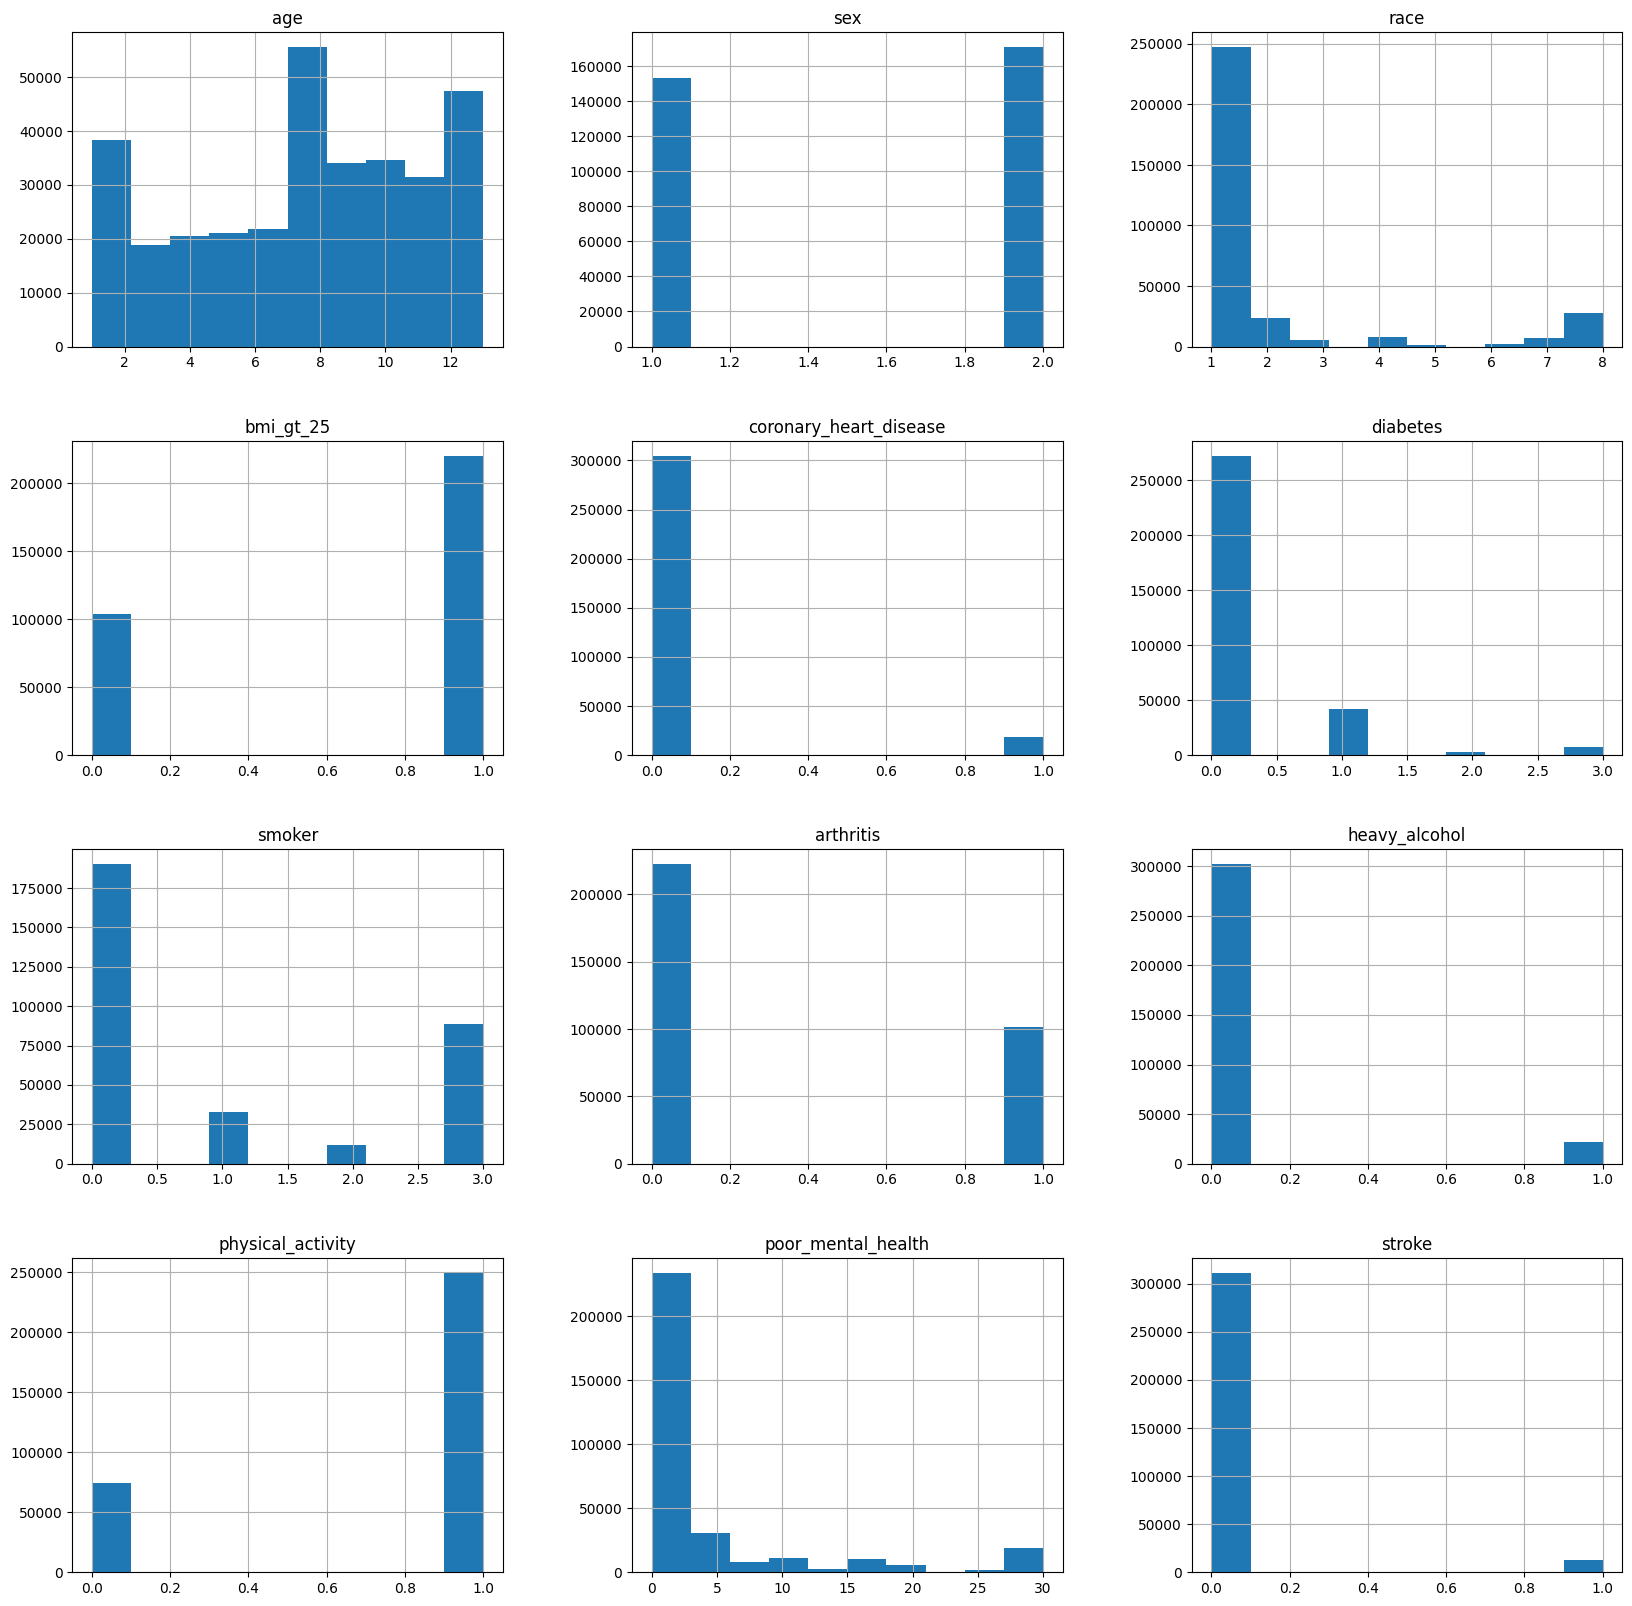

In [20]:
risk_factors.hist(figsize=(20,20))
plt.show()

**Proportion of class `stroke` to each risk factor**

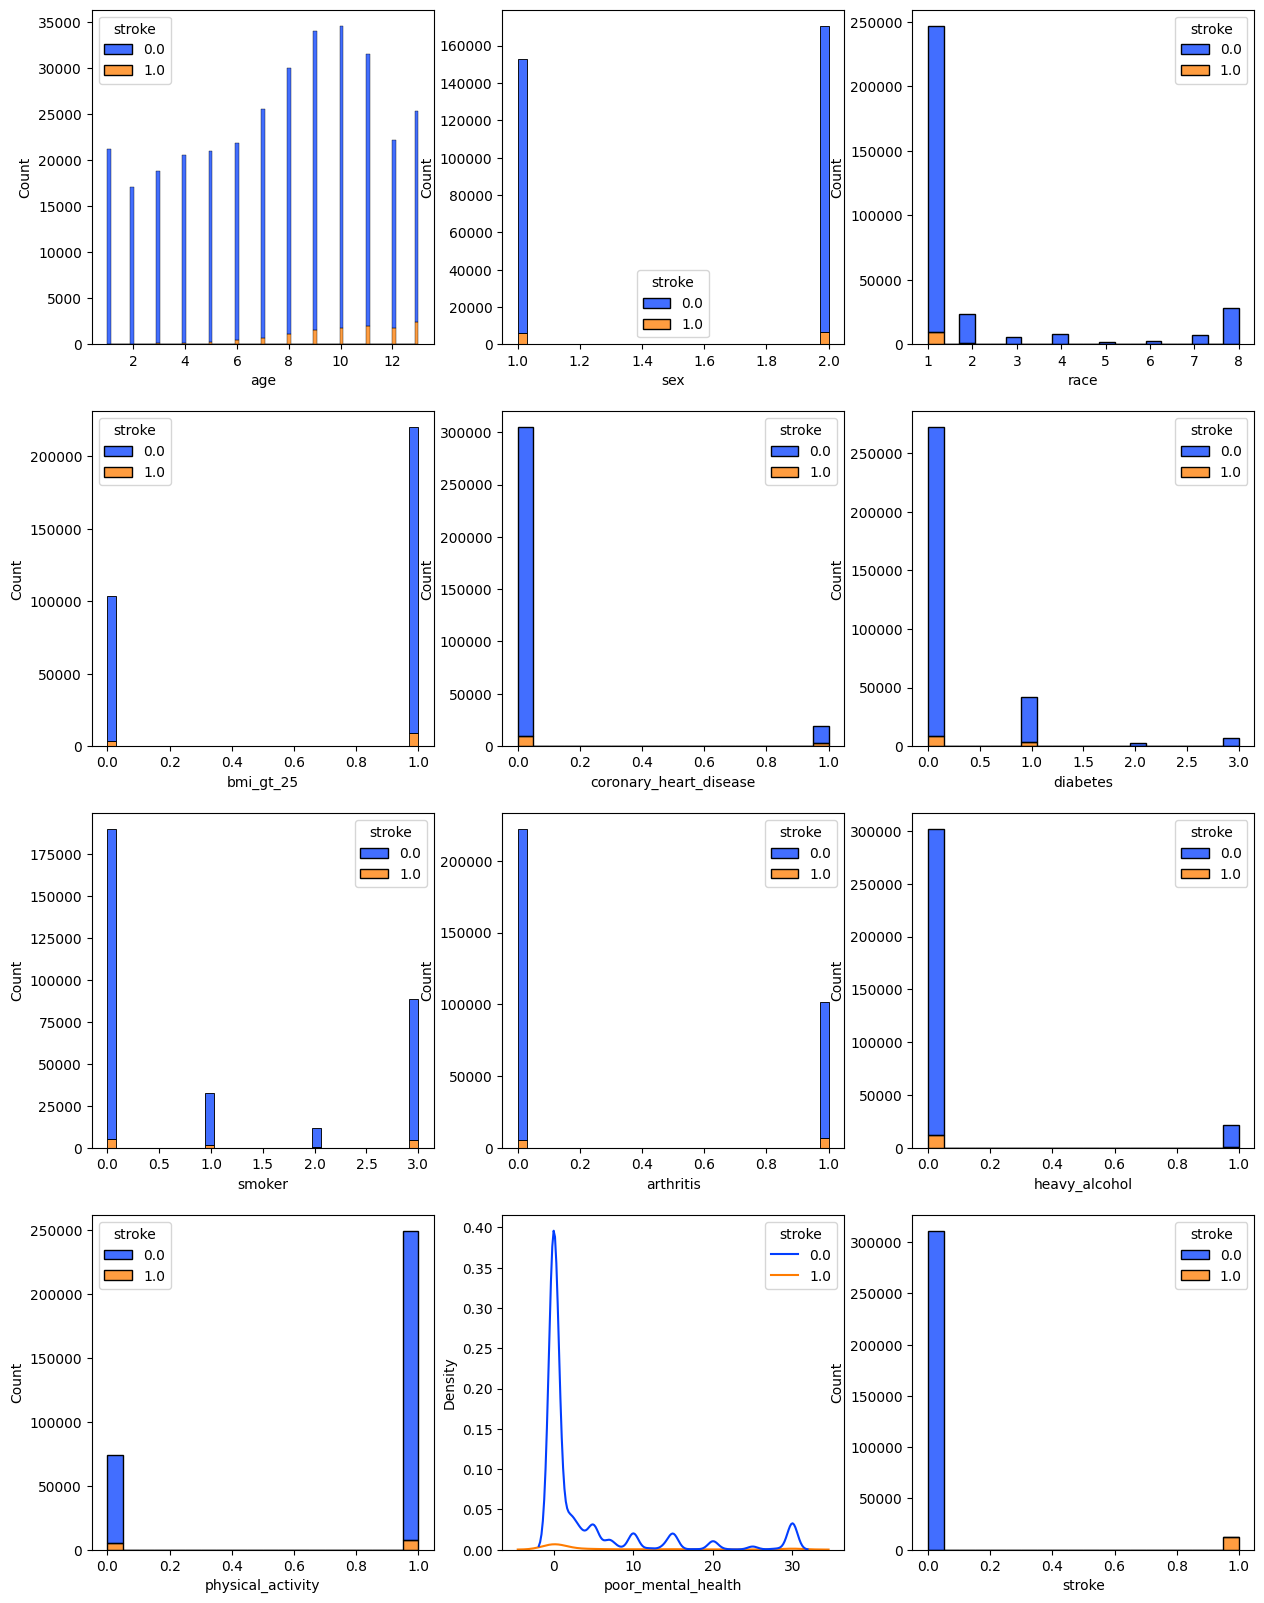

In [21]:
fig, ax = plt.subplots(4, 3, figsize=(15, 20))
i = 0
for col in risk_factors.columns:
    if col=='poor_mental_health':
        sns.kdeplot(data=risk_factors, x=col, hue='stroke', ax=ax[i//3, i%3], palette='bright')
    else:
        sns.histplot(data=risk_factors, x=col, hue='stroke', ax=ax[i//3, i%3], multiple="stack", palette='bright')
    i+=1
plt.show()

### 2.2. Correlation

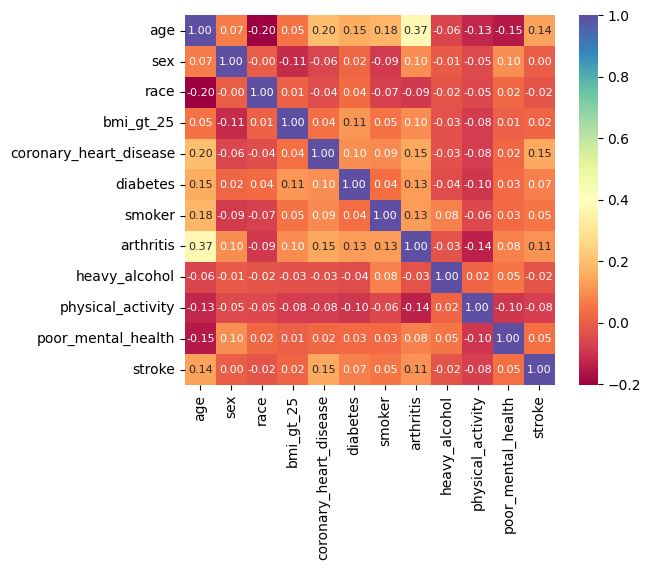

In [28]:
corr_mat = risk_factors.corr()
heatmap = sns.heatmap(corr_mat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 8}, 
                 yticklabels=risk_factors.columns, 
                 xticklabels=risk_factors.columns, 
                 cmap="Spectral")
plt.show()